In [1]:
%matplotlib inline
import nibabel as nib
import numpy as np
from scipy import ndimage
from keras import backend as K
from sklearn.metrics import accuracy_score, precision_score

from utils import *
from model_FCNN import generate_model


Using TensorFlow backend.


In [2]:
from importlib import reload

import keras
reload(keras)
from keras import backend as K

import utils
reload(utils)
from utils import *

import model_FCNN
reload(model_FCNN)
from model_FCNN import generate_model

import callback_custom
reload(callback_custom);

# Problem configuration

In [3]:
num_classes = 11
num_channel = 2

# K-fold validation (K=5)
n_training = 16
n_test = 4

#idxs_training = list(range(1, 1+16))
#idxs_test = list(range(17, 17+4))
idxs_training = list(range(1, 1+12)) + list(range(17, 17+4))
idxs_test = list(range(13,13+4))

patience = 5
model_filename = 'models/outrun_step_{}.h5'
csv_filename = 'log/outrun_step_{}.cvs'

nb_epoch = 40
validation_split = 0.10
monitor = 'val_loss'#'val_categorical_accuracy'

class_mapper = {0:0}
class_mapper.update({ i+1:i for i in range(1, 1+10) })
class_mapper_inv = {0:0}
class_mapper_inv.update({ i:i+1 for i in range(1, 1+10) })

matrix_size = (160, 220, 48)

extraction_step = (3, 3, 1)
#extraction_step = (5, 5, 3)

segment_size = (27, 27, 21)
core_size = (9, 9, 3)

# Architecture

# 1. Initial segmentation

## 1.1 Read data

In [4]:
QSM_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
MAG_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
R2S_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
label_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
for i, case_idx in enumerate(idxs_training):
    QSM_train[i, :, :, :] = read_data(case_idx, 'QSM')
    MAG_train[i, :, :, :] = read_data(case_idx, 'MAG')
    R2S_train[i, :, :, :] = read_data(case_idx, 'R2S')
    label_train[i, :, :, :] = read_data(case_idx, 'label')

In [5]:
#data_train = np.stack((QSM_train, MAG_train, R2S_train), axis = 1)
data_train = np.stack((QSM_train, R2S_train), axis = 1)
#data_train = np.stack((QSM_train,), axis = 1)

In [6]:
QSM_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
MAG_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
R2S_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
label_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
for i, case_idx in enumerate(idxs_test):
    QSM_test[i, :, :, :] = read_data(case_idx, 'QSM')
    MAG_test[i, :, :, :] = read_data(case_idx, 'MAG')
    R2S_test[i, :, :, :] = read_data(case_idx, 'R2S')
    label_test[i, :, :, :] = read_data(case_idx, 'label')

In [7]:
#data_test = np.stack((QSM_test, MAG_test, R2S_test), axis = 1)
data_test = np.stack((QSM_test, R2S_test), axis = 1)
#data_test = np.stack((QSM_test,), axis = 1)

## 1.2 Pre-processing

In [8]:
## Intensity normalisation (zero mean and unit variance)
input_mean = 127.0
input_std = 128.0
data_train = (data_train - input_mean) / input_std
data_test = (data_test - input_mean) / input_std

# Map class label
tmp = np.copy(label_train)
for class_idx in class_mapper:
    label_train[tmp == class_idx] = class_mapper[class_idx]
tmp = np.copy(label_test)
for class_idx in class_mapper:
    label_test[tmp == class_idx] = class_mapper[class_idx]
del tmp

In [9]:
label_train.max()

10.0

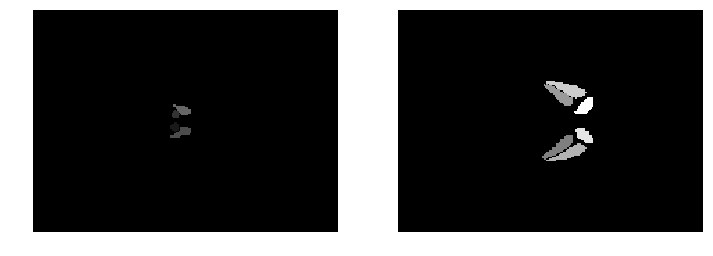

In [10]:
plots(np.squeeze(label_train[0,:,:,[29,25]]), scale = (0, 10))

## 1.3 Data preparation

In [11]:
x_train, y_train = build_set(data_train, label_train, extraction_step, segment_size, core_size)
x_train.shape, y_train.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


((32629, 2, 27, 27, 21), (32629, 243, 11))

In [12]:
# shuffle array
idxs_shuffle = shuffle(x_train)
idxs_shuffle = shuffle(y_train, idxs_shuffle)

## 1.4 Configure callbacks

In [13]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

from callback_custom import EarlyStoppingLowLR
from callback_custom import ReduceLROnPlateauBestWeight



# Model checkpoint to save the training results
checkpointer = ModelCheckpoint(
    filepath=model_filename.format('1'),
    monitor=monitor,
    verbose=0,
    save_best_only=True,
    save_weights_only=True)

# CSVLogger to save the training results in a csv file
csv_logger = CSVLogger(csv_filename.format(1), separator=';')


stopper = EarlyStoppingLowLR(patience=patience, monitor=monitor, thresh_LR=1e-5)

learning_rate_reduction = ReduceLROnPlateauBestWeight(filepath=model_filename.format('1'),
                                                      monitor=monitor, 
                                                      patience=patience, 
                                                      verbose=1, 
                                                      factor=0.1, 
                                                      min_lr=1.001e-5)

callbacks = [checkpointer, csv_logger, learning_rate_reduction, stopper]

## 1.5 Training

In [14]:
seed = 47
np.random.seed(seed)

# Build model
model = generate_model(num_classes, num_channel, segment_size, core_size)

K.set_value(model.optimizer.lr, 1e-3)

model.fit(
    x_train,
    y_train,
    epochs=nb_epoch,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

# freeing space
#del x_train
#del y_train

Train on 29366 samples, validate on 3263 samples
Epoch 1/40
29366/29366 [==============================] - 182s 6ms/step - loss: 0.3901 - categorical_accuracy: 0.8737 - val_loss: 0.2947 - val_categorical_accuracy: 0.9054
Epoch 2/40
29366/29366 [==============================] - 180s 6ms/step - loss: 0.0921 - categorical_accuracy: 0.9624 - val_loss: 0.4249 - val_categorical_accuracy: 0.9055
Epoch 3/40
29366/29366 [==============================] - 181s 6ms/step - loss: 0.0459 - categorical_accuracy: 0.9814 - val_loss: 0.4917 - val_categorical_accuracy: 0.9111
Epoch 4/40
29366/29366 [==============================] - 181s 6ms/step - loss: 0.0224 - categorical_accuracy: 0.9915 - val_loss: 0.5812 - val_categorical_accuracy: 0.9204
Epoch 5/40
29366/29366 [==============================] - 181s 6ms/step - loss: 0.0151 - categorical_accuracy: 0.9946 - val_loss: 0.6244 - val_categorical_accuracy: 0.9171
Epoch 6/40
29366/29366 [==============================] - 181s 6ms/step - loss: 0.0105 - ca

## 1.6 Classification

In [15]:
from keras.models import load_model

# Load best model
model = generate_model(num_classes, num_channel, segment_size, core_size)
model.load_weights(model_filename.format(1))

In [16]:
idx_start_valid = int(len(x_train)*validation_split)
model.evaluate(x_train[-idx_start_valid:], y_train[-idx_start_valid:], verbose=1)

3262/3262 [==============================] - 3s 893us/step


[0.29481033337657103, 0.90539377405188848]

In [17]:
len_patch = extract_patches(read_data(1, 'QSM'), patch_shape=segment_size, extraction_step=(9, 9, 3)).shape[0]
len_patch

3300

In [38]:
segmentations_train = []

for i_case, case_idx in enumerate(idxs_training):

    print(case_idx)
    input_train = data_train[i_case, :, :, :, :]

    x_test = np.zeros((len_patch, num_channel,) + segment_size, dtype=precision_global)
    for i_channel in range(num_channel):
        x_test[:, i_channel, :, :, :] = extract_patches(input_train[i_channel], patch_shape=segment_size, extraction_step=(9, 9, 3))

    pred = model.predict(x_test, verbose=1)
    pred_classes = np.argmax(pred, axis=2)
    pred_classes = pred_classes.reshape((len(pred_classes), 9, 9, 3))
    segmentation = reconstruct_volume(pred_classes, matrix_size)
    
    segmentations_train = segmentations_train + [segmentation]
    
segmentations_train = np.stack(segmentations_train, axis=0)

1
3300/3300 [==============================] - 2s 740us/step
2
3300/3300 [==============================] - 2s 744us/step
3
3300/3300 [==============================] - 3s 773us/step
4
3300/3300 [==============================] - 2s 747us/step
5
3300/3300 [==============================] - 2s 746us/step
6
3300/3300 [==============================] - 2s 752us/step
7
3300/3300 [==============================] - 2s 752us/step
8
3300/3300 [==============================] - 2s 754us/step
9
3300/3300 [==============================] - 2s 754us/step
10
3300/3300 [==============================] - 2s 757us/step
11
3300/3300 [==============================] - 2s 756us/step
12
3300/3300 [==============================] - 2s 757us/step
17
3300/3300 [==============================] - 2s 757us/step
18
3300/3300 [==============================] - 3s 760us/step
19
3300/3300 [==============================] - 2s 757us/step
20
3300/3300 [==============================] - 3s 782us/step


In [19]:
segmentations_train.max()

10.0

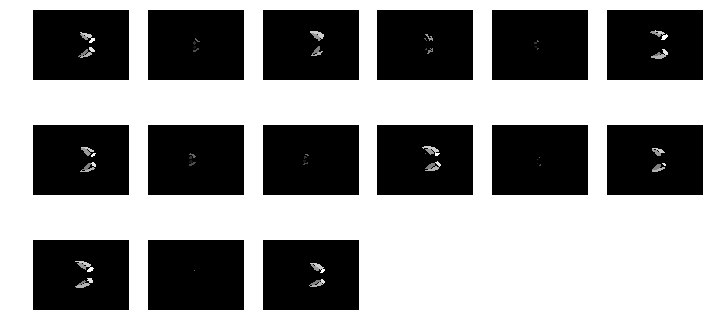

In [20]:
plots(np.squeeze(label_train[0:15,:,:,25]), rows=3, scale = (0, 10))

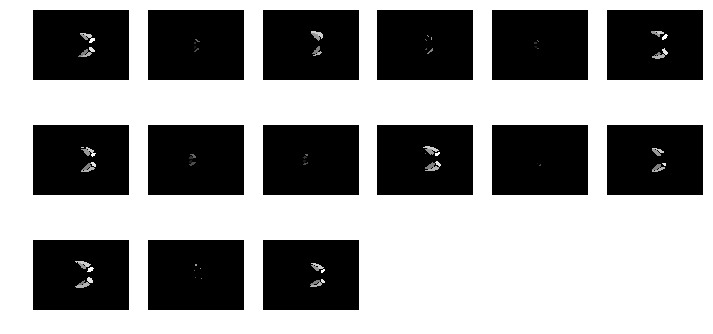

In [39]:
plots(np.squeeze(segmentations_train[0:15,:,:,25]), rows=3, scale = (0, 10))

## 1.7 Check false-positive

In [22]:
idx_fpos = (label_train == 0) & (segmentations_train != 0);

In [23]:
mask_fpos = np.zeros(label_train.shape, dtype=precision_global)
mask_fpos[idx_fpos == True] = 1

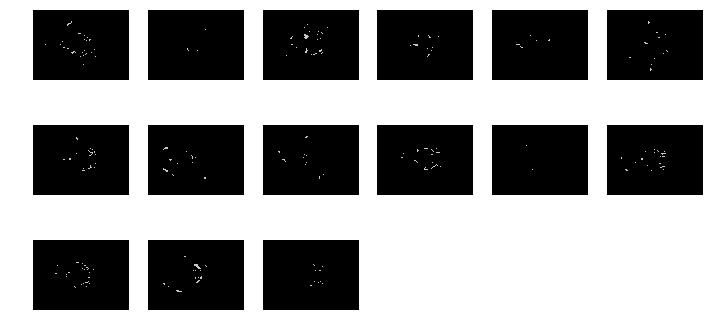

In [24]:
plots(200*(np.squeeze(mask_fpos[0:15,:,:,25])), rows=3)

# 2 Fine-tuning

## 2.2 Rebuild training dataset

In [25]:
del x_train, y_train

In [26]:
extraction_step_ft = (6,6,3)
x_train, y_train = build_set(data_train, label_train, extraction_step_ft, segment_size, core_size, mask_fpos)
x_train.shape, y_train.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


((10547, 2, 27, 27, 21), (10547, 243, 11))

In [27]:
# shuffle array
#idxs_shuffle = shuffle(x_train)
#idxs_shuffle = shuffle(y_train, idxs_shuffle)

In [28]:
save_array('tmp/x_train.bc', x_train)
save_array('tmp/y_train.bc', y_train)

In [29]:
#x_train = load_array('tmp/x_train.bc')
#y_train = load_array('tmp/y_train.bc')

## 2.3 Regenerate model

In [30]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

from callback_custom import EarlyStoppingLowLR
from callback_custom import ReduceLROnPlateauBestWeight



# Model checkpoint to save the training results
checkpointer = ModelCheckpoint(
    filepath=model_filename.format('2'),
    monitor=monitor,
    verbose=0,
    save_best_only=True,
    save_weights_only=True)

# CSVLogger to save the training results in a csv file
csv_logger = CSVLogger(csv_filename.format(1), separator=';')


stopper = EarlyStoppingLowLR(patience=patience, monitor=monitor, thresh_LR=1e-5)

learning_rate_reduction = ReduceLROnPlateauBestWeight(filepath=model_filename.format('2'),
                                                      monitor=monitor, 
                                                      patience=patience, 
                                                      verbose=1, 
                                                      factor=0.1, 
                                                      min_lr=1.001e-5)

callbacks = [checkpointer, csv_logger, learning_rate_reduction, stopper]

In [31]:
# Build model
model = generate_model(num_classes, num_channel, segment_size, core_size)

# Load optimized weights
model.load_weights(model_filename.format('1'))

K.set_value(model.optimizer.lr, 1e-4)

# Start fine-tuning
model.fit(
    x_train,
    y_train,
    epochs=nb_epoch,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

# freeing space
#del x_train
#del y_train

Train on 9492 samples, validate on 1055 samples
Epoch 1/40
9492/9492 [==============================] - 57s 6ms/step - loss: 0.0449 - categorical_accuracy: 0.9833 - val_loss: 0.0039 - val_categorical_accuracy: 0.9987
Epoch 2/40
9492/9492 [==============================] - 57s 6ms/step - loss: 0.0327 - categorical_accuracy: 0.9870 - val_loss: 0.0015 - val_categorical_accuracy: 0.9996
Epoch 3/40
9492/9492 [==============================] - 57s 6ms/step - loss: 0.0290 - categorical_accuracy: 0.9883 - val_loss: 0.0017 - val_categorical_accuracy: 0.9995
Epoch 4/40
9492/9492 [==============================] - 58s 6ms/step - loss: 0.0266 - categorical_accuracy: 0.9892 - val_loss: 8.2780e-04 - val_categorical_accuracy: 0.9997
Epoch 5/40
9492/9492 [==============================] - 58s 6ms/step - loss: 0.0250 - categorical_accuracy: 0.9898 - val_loss: 0.0017 - val_categorical_accuracy: 0.9994
Epoch 6/40
9492/9492 [==============================] - 58s 6ms/step - loss: 0.0221 - categorical_accur

In [32]:
# Load best model
model = generate_model(num_classes, num_channel, segment_size, core_size)
model.load_weights(model_filename.format('2'))

In [33]:
idx_start_valid = int(len(x_train)*validation_split)
model.evaluate(x_train[-idx_start_valid:], y_train[-idx_start_valid:], verbose=1)

1054/1054 [==============================] - 1s 923us/step


[0.00082844707712158207, 0.99971090367442061]

In [40]:
segmentations_test = []

for i_case, case_idx in enumerate(idxs_test):

    print(case_idx)
    input_test = data_test[i_case, :, :, :, :]

    x_test = np.zeros((len_patch, num_channel,) + segment_size, dtype=precision_global)
    for i_channel in range(num_channel):
        x_test[:, i_channel, :, :, :] = extract_patches(input_test[i_channel], patch_shape=segment_size, extraction_step=(9, 9, 3))

    pred = model.predict(x_test, verbose=1)
    pred_classes = np.argmax(pred, axis=2)
    pred_classes = pred_classes.reshape((len(pred_classes), 9, 9, 3))
    segmentation = reconstruct_volume(pred_classes, matrix_size)
    #segmentation = reconstruct_volume_majority(pred_classes, matrix_size, extraction_step=(3, 3, 3))
    
    segmentations_test = segmentations_test + [segmentation]
    
segmentations_test = np.stack(segmentations_test, axis=0)

13
3300/3300 [==============================] - 2s 757us/step
14
3300/3300 [==============================] - 2s 756us/step
15
3300/3300 [==============================] - 2s 746us/step
16
3300/3300 [==============================] - 2s 749us/step


In [41]:
segmentations_test.max()

10.0

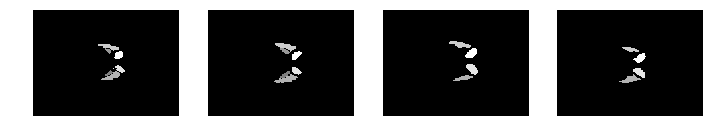

In [42]:
plots(np.squeeze(label_test[:,:,:,23]), rows=1, scale = (0, 10))

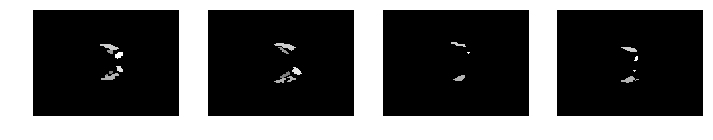

In [43]:
plots(np.squeeze(segmentations_test[:,:,:,23]), rows=1, scale = (0, 10))

# 3 Post-processing

## 3.1 Pick the largest connected component for each class

In [44]:
for i_case, case_idx in enumerate(idxs_test):
    segmentation = np.squeeze(segmentations_test[i_case,:,:,:]);
    tmp = np.zeros(segmentation.shape, dtype=segmentation.dtype)
    
    for class_idx in class_mapper_inv :
        mask = (segmentation == class_idx)
        
        if class_idx != 0 and mask.sum() > 0:
            labeled_mask, num_cc = ndimage.label(mask)
            largest_cc_mask = (labeled_mask == (np.bincount(labeled_mask.flat)[1:].argmax() + 1))
            
            tmp[largest_cc_mask == 1] = class_idx
        
    segmentations_test[i_case,:,:,:] = tmp

## 3.2 Save it 

In [45]:
for i_case, case_idx in enumerate(idxs_test):
    print(case_idx)
    
    segmentation = np.copy(np.squeeze(segmentations_test[i_case,:,:,:]))
    
    tmp = np.copy(segmentation)
    for class_idx in class_mapper_inv:
        segmentation[tmp == class_idx] = class_mapper_inv[class_idx]
    del tmp

    save_data(segmentation, case_idx, 'label')    

print("Done with Step 3")

13
14
15
16
Done with Step 3


## 3.3 Calculate metric 

In [46]:
def calc_dice(m1, m2):
    return 2*((m1==1) & (m2==1)).sum()/((m1==1).sum() + (m2==1).sum())

In [47]:
for i_case, case_idx in enumerate(idxs_test):
    print(case_idx, end='\t')
    print('{:.4f}'.format(accuracy_score(label_test[i_case,:,:,:].flat, segmentations_test[i_case,:,:,:].flat)), end='\t')
    for class_idx in class_mapper_inv:
        mask = (np.squeeze(segmentations_test[i_case,:,:,:]) == class_idx)
        if class_idx != 0 and mask.sum() > 0:
            print('{:.4f}'.format(precision_score(label_test[i_case,:,:,:][mask], segmentations_test[i_case,:,:,:][mask], average='micro')), end='\t')
        else:
            print('N/A', end='\t')
    print()

13	0.9993	N/A	0.8889	0.9434	0.8922	0.9892	0.9177	0.9281	0.9210	0.8951	0.8536	0.9389	
14	0.9985	N/A	0.9796	0.9839	0.8617	0.9679	0.8262	0.7761	0.9261	0.9201	0.9072	N/A	
15	0.9981	N/A	0.9524	1.0000	0.8452	0.8842	0.9633	0.9879	0.9107	1.0000	0.9889	1.0000	
16	0.9986	N/A	0.9231	0.9474	0.8778	0.8808	0.8864	0.9556	0.9599	0.9180	1.0000	0.8636	


In [48]:
for i_case, case_idx in enumerate(idxs_test):
    print(case_idx, end='\t')
    for class_idx in class_mapper_inv:
        mask = (np.squeeze(segmentations_test[i_case,:,:,:]) == class_idx)
        if class_idx != 0 and mask.sum() > 0:
            print('{:.4f}'.format(calc_dice((label_test[i_case,:,:,:]==class_idx).flat, (segmentations_test[i_case,:,:,:]==class_idx).flat)), end='\t')
        else:
            print(0, end='\t')
    print()

13	0	0.8205	0.8475	0.8445	0.8026	0.9161	0.8558	0.8701	0.7800	0.6846	0.7376	
14	0	0.8727	0.6421	0.8417	0.8229	0.8459	0.8232	0.5165	0.7031	0.7002	0	
15	0	0.7619	0.3836	0.9034	0.7814	0.9164	0.9142	0.5249	0.2778	0.1926	0.0743	
16	0	0.8623	0.8623	0.9159	0.8339	0.9007	0.9232	0.7769	0.7635	0.0109	0.0968	
